In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data=kagglehub.dataset_download('snap/amazon-fine-food-reviews')
csv_file=os.path.join(data,'Reviews.csv')
df=pd.read_csv(csv_file)
df.head(2)

Using Colab cache for faster access to the 'amazon-fine-food-reviews' dataset.


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [ ]:
df.isnull().sum()

,0
Id,0
ProductId,0
UserId,0
ProfileName,26
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,27
Text,0


In [ ]:
df_clean=df[['Text','Score']]
df_clean.head(2)

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1


In [ ]:
df_clean.isnull().sum()

,0
Text,0
Score,0


In [ ]:
df_clean.isin(['','?','unknown']).sum()

,0
Text,0
Score,0


In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Text    568454 non-null  object
 1   Score   568454 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 8.7+ MB


In [ ]:
score_count=df_clean['Score'].value_counts().sort_index()
for score,count in score_count.items():
  percentage=(count/len(df_clean))*100
  print(f'{score} stars:{percentage:.2f}')

1 stars:9.19
2 stars:5.24
3 stars:7.50
4 stars:14.19
5 stars:63.88


In [ ]:
for i in range(1,6):
  review=df_clean[df_clean['Score']==i]['Text'].iloc[0]
  print(f"\n⭐ {i}-STAR REVIEW:")
  print(f" '{review}'")


⭐ 1-STAR REVIEW:
 'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".'

⭐ 2-STAR REVIEW:
 'If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The flavor is very medicinal.'

⭐ 3-STAR REVIEW:
 'This seems a little more wholesome than some of the supermarket brands, but it is somewhat mushy and doesn't have quite as much flavor either.  It didn't pass muster with my kids, so I probably won't buy it again.'

⭐ 4-STAR REVIEW:
 'This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I hig

In [ ]:
df_clean['text_length']=df_clean['Text'].str.len()
df_clean['word_count']=df_clean['Text'].str.split().str.len()

In [ ]:
df_clean.head(2)

,Text,Score,text_length,word_count
0,I have bought several of the Vitality canned d...,5,263,48
1,Product arrived labeled as Jumbo Salted Peanut...,1,190,31


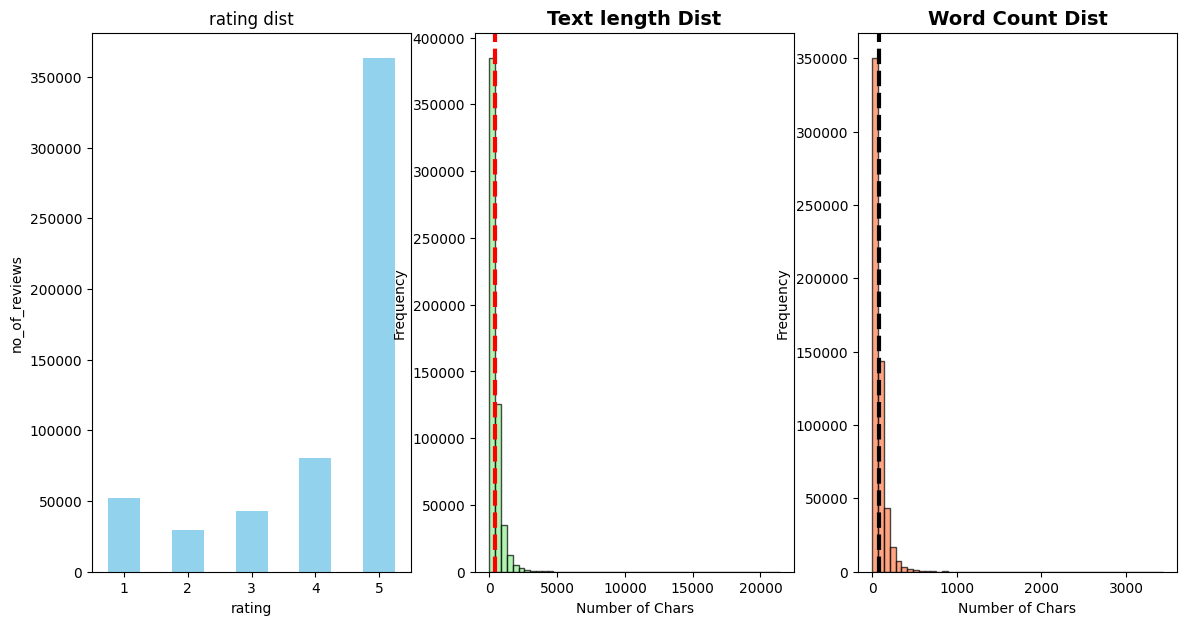

In [ ]:
plt.figure(figsize=(14,7))
plt.subplot(1,3,1)
score_count.plot(kind='bar',color='skyblue',alpha=0.9)
plt.title('rating dist')
plt.xlabel('rating')
plt.ylabel('no_of_reviews')
plt.xticks(rotation=0)

plt.subplot(1,3,2)
plt.hist(df_clean['text_length'], bins=50, alpha=0.7, color='lightgreen',edgecolor='black')
plt.title("Text length Dist", fontsize=14, fontweight='bold')
plt.xlabel("Number of Chars")
plt.ylabel("Frequency")
plt.axvline(df_clean['text_length'].mean(), color='red',linestyle='--',
            linewidth=3,label=f"Mean:{df_clean['text_length'].mean()}")

plt.subplot(1,3,3)
plt.hist(df_clean['word_count'], bins=50, alpha=0.7, color='coral',edgecolor='black')
plt.title("Word Count Dist", fontsize=14, fontweight='bold')
plt.xlabel("Number of Chars")
plt.ylabel("Frequency")
plt.axvline(df_clean['word_count'].mean(), color='black',linestyle='--',
            linewidth=3,label=f"Mean:{df_clean['word_count'].mean()}")

In [ ]:
df_binary=df_clean[df_clean['Score']!=3].copy()
df_binary['sentiment']=(df_binary['Score']>=4).astype(int)

In [ ]:
df_binary

,Text,Score,text_length,word_count,sentiment
0,I have bought several of the Vitality canned d...,5,263,48,1
1,Product arrived labeled as Jumbo Salted Peanut...,1,190,31,0
2,This is a confection that has been around a fe...,4,509,94,1
3,If you are looking for the secret ingredient i...,2,219,41,0
4,Great taffy at a great price. There was a wid...,5,140,27,1
...,...,...,...,...,...
568449,Great for sesame chicken..this is a good if no...,5,149,26,1
568450,I'm disappointed with the flavor. The chocolat...,2,252,46,0
568451,"These stars are small, so you can give 10-15 o...",5,372,66,1
568452,These are the BEST treats for training and rew...,5,200,35,1


In [ ]:
df_binary['sentiment'].value_counts()

,count
sentiment,
1,443777
0,82037


In [ ]:
#handle the class imblance
from sklearn.utils import resample
negative_reviews = df_binary[df_binary['sentiment']== 0]
positive_reviews = df_binary[df_binary['sentiment']== 1]

print(f"Original Imbalance")
negative_pct = (sum(df_binary['sentiment']==0)/len(df_binary))*100
positive_pct = (sum(df_binary['sentiment']==1)/len(df_binary))*100
print(f"negative_pct : {negative_pct:.2f}%")
print(f"positive_pct : {positive_pct:.2f}%")

#technique - under sampling
n_minority = len(negative_reviews)
positive_downsampled = resample(positive_reviews,
                                replace=False,
                                n_samples=n_minority,
                                random_state=42)
df_balanced = pd.concat([negative_reviews,positive_downsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"After Imbalance")
print(f"Negative: {sum(df_balanced['sentiment']==0):,} ({sum(df_balanced['sentiment']==0)/len(df_balanced)*100:.1f})%")
print(f"Positive: {sum(df_balanced['sentiment']==1):,} ({sum(df_balanced['sentiment']==1)/len(df_balanced)*100:.1f})%")

Original Imbalance
negative_pct : 15.60%
positive_pct : 84.40%
After Imbalance
Negative: 82,037 (50.0)%
Positive: 82,037 (50.0)%


In [ ]:
import re

def clean_text(text):
  text=text.lower()
  text=re.sub(r'[^a-zA-Z\s]','',text)
  text=' '.join(text.split())
  return text
print('og text')
print(df_balanced['Text'].iloc[0])
print('clean text')
print(clean_text(df_balanced['Text'].iloc[0]))

og text
First of all, let me say that my dog likes the taste of this treat - a lot. However, I have a large dog...and evidently an impatient dog. Rather than lick this "roll-on" treat, she would rather just bite it and chew it. That's really the only down side. Found out my daughters kitten liked it too. It's weird, like a 1980's deodorant company trying to do something profitable with their out of date product line. I wouldn't buy it, but my pets liked it.
clean text
first of all let me say that my dog likes the taste of this treat a lot however i have a large dogand evidently an impatient dog rather than lick this rollon treat she would rather just bite it and chew it thats really the only down side found out my daughters kitten liked it too its weird like a s deodorant company trying to do something profitable with their out of date product line i wouldnt buy it but my pets liked it


In [ ]:
df_balanced['clean_Text']=df_balanced['Text'].apply(clean_text)

In [ ]:
df_balanced.head()

,Text,Score,text_length,word_count,sentiment,clean_Text
0,"First of all, let me say that my dog likes the...",2,453,85,0,first of all let me say that my dog likes the ...
1,"I had really high hopes for this coffee, it sm...",1,364,73,0,i had really high hopes for this coffee it sme...
2,I have tried all the varieties of Special K ce...,1,221,42,0,i have tried all the varieties of special k ce...
3,I placed an order for Dogswell Happy Hips for ...,1,991,187,0,i placed an order for dogswell happy hips for ...
4,"I usually dont like black herbal tea, but this...",5,316,64,1,i usually dont like black herbal tea but this ...


In [ ]:
Max_Features=10000
Max_Len=100

x=df_balanced['clean_Text'].values
y=df_balanced['sentiment'].values

tokenizer=Tokenizer(num_words=Max_Features,oov_token='<OOV>')
tokenizer.fit_on_texts(x)

x_sequences=tokenizer.texts_to_sequences(x)


In [ ]:
x_paaded=pad_sequences(x_sequences,maxlen=Max_Len,padding='post',truncating='post')

In [ ]:
x_paaded[0]

array([  97,    8,   40,  420,   49,  168,   13,   14,   95,  568,    2,
         32,    8,    9,  256,    5,  190,  169,    3,   18,    5,  377,
          1, 5999,   72, 9992,   95,  406,   62, 1616,    9, 5235,  256,
         81,   45,  406,   34,  603,    7,    4,  534,    7,  278,   69,
          2,   68,  215,  487,  126,   55,   14, 2193, 1802,  440,    7,
         78,   42,  875,   26,    5, 1289, 3636,  264,  273,    6,   77,
        141,    1,   19,   98,   55,    8,  454,   37,  646,    3,  396,
         79,    7,   17,   14, 1161,  440,    7,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(
    x_paaded,y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

In [ ]:
def create_rnn_model():
  model=Sequential([
      Embedding(input_dim=Max_Features,output_dim=128,input_length=Max_Len),
      SimpleRNN(units=64,return_sequences=False),
      Dropout(0.5),
      Dense(64,activation='relu'),
      Dense(32,activation='relu'),
      Dense(1,activation='sigmoid')
  ])
  return model

rnn_model=create_rnn_model()
rnn_model.compile(
      optimizer=Adam(learning_rate=0.01),
      loss='binary_crossentropy',
      metrics=['accuracy']
  )

In [ ]:
rnn_history=rnn_model.fit(
    x_train,y_train,
    batch_size=128,
    epochs=5,
    validation_split=0.20
)

Epoch 1/5
821/821 ━━━━━━━━━━━━━━━━━━━━ 75s 88ms/step - accuracy: 0.5010 - loss: 0.6976 - val_accuracy: 0.4969 - val_loss: 0.6937
Epoch 2/5
821/821 ━━━━━━━━━━━━━━━━━━━━ 75s 80ms/step - accuracy: 0.4997 - loss: 0.6933 - val_accuracy: 0.5031 - val_loss: 0.6931
Epoch 3/5
821/821 ━━━━━━━━━━━━━━━━━━━━ 70s 86ms/step - accuracy: 0.4985 - loss: 0.6933 - val_accuracy: 0.4969 - val_loss: 0.6937
Epoch 4/5
821/821 ━━━━━━━━━━━━━━━━━━━━ 71s 86ms/step - accuracy: 0.4974 - loss: 0.6933 - val_accuracy: 0.5031 - val_loss: 0.6931
Epoch 5/5
821/821 ━━━━━━━━━━━━━━━━━━━━ 68s 69ms/step - accuracy: 0.4991 - loss: 0.6933 - val_accuracy: 0.5031 - val_loss: 0.6932


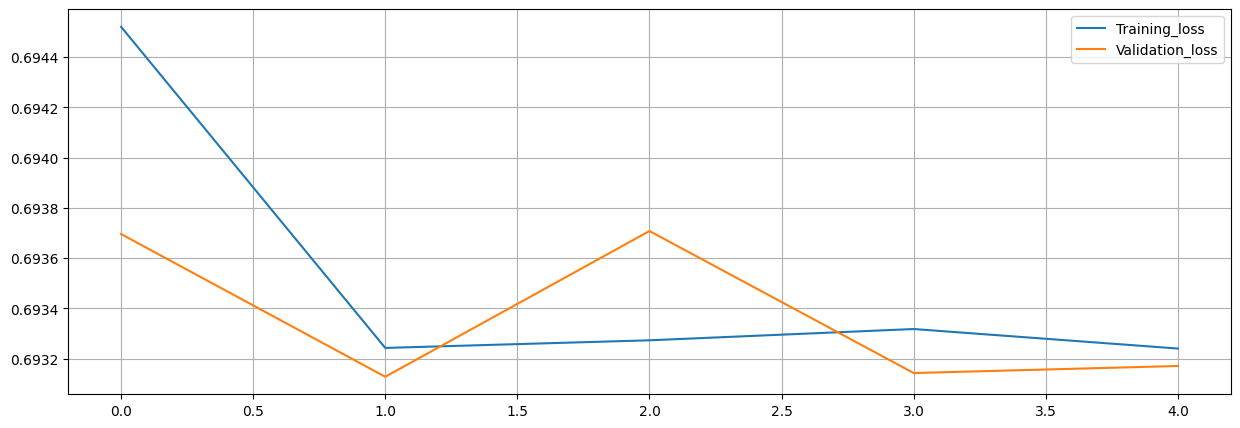

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(rnn_history.history['loss'],label='Training_loss',)
plt.plot(rnn_history.history['val_loss'],label='Validation_loss')
plt.grid()
plt.legend()

In [ ]:
def create_lstm_model():
  model=Sequential([
      Embedding(input_dim=Max_Features,output_dim=128,input_length=Max_Len),
      LSTM(units=64,return_sequences=False),
      Dropout(0.5),
      Dense(64,activation='relu'),
      Dense(32,activation='relu'),
      Dense(1,activation='sigmoid')
  ])
  return model

lstm_model=create_lstm_model()
lstm_model.compile(
      optimizer=Adam(learning_rate=0.01),
      loss='binary_crossentropy',
      metrics=['accuracy']
  )
lstm_history=lstm_model.fit(
    x_train,y_train,
    batch_size=128,
    epochs=5,
    validation_split=0.20
)

Epoch 1/5
821/821 ━━━━━━━━━━━━━━━━━━━━ 170s 202ms/step - accuracy: 0.6445 - loss: 0.5774 - val_accuracy: 0.8855 - val_loss: 0.2905
Epoch 2/5
821/821 ━━━━━━━━━━━━━━━━━━━━ 165s 201ms/step - accuracy: 0.8963 - loss: 0.2608 - val_accuracy: 0.8962 - val_loss: 0.2551
Epoch 3/5
821/821 ━━━━━━━━━━━━━━━━━━━━ 165s 201ms/step - accuracy: 0.9118 - loss: 0.2276 - val_accuracy: 0.9012 - val_loss: 0.2597
Epoch 4/5
821/821 ━━━━━━━━━━━━━━━━━━━━ 173s 211ms/step - accuracy: 0.9201 - loss: 0.2117 - val_accuracy: 0.9013 - val_loss: 0.2524
Epoch 5/5
821/821 ━━━━━━━━━━━━━━━━━━━━ 166s 202ms/step - accuracy: 0.9236 - loss: 0.2027 - val_accuracy: 0.8994 - val_loss: 0.2547


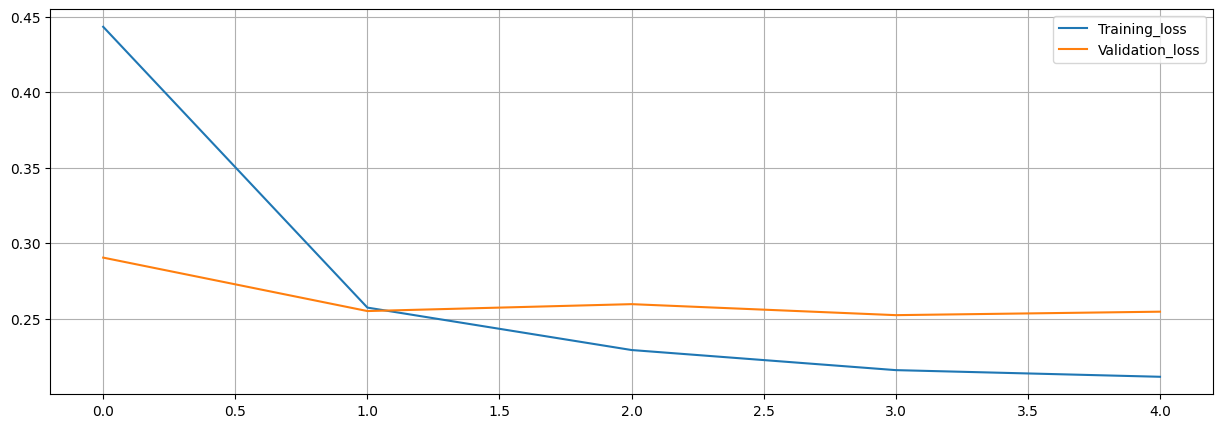

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(lstm_history.history['loss'],label='Training_loss',)
plt.plot(lstm_history.history['val_loss'],label='Validation_loss')
plt.grid()
plt.legend()

CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense

In [ ]:
(x_train,y_train),(x_test,y_test)=mnist.load_data()

In [ ]:
x_train=x_train/255
x_test=x_test/255
# y_train contains class labels (0-9), not pixel values, and should not be scaled.

In [ ]:
x_train=x_train.reshape(-1,28,28,1)
x_test=x_test.reshape(-1,28,28,1)

In [ ]:
model=Sequential([
    Conv2D(32,(3,3),activation='relu',input_shape=(28,28,1)),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128,activation='relu'),
    Dense(10,activation='softmax')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', # Changed to sparse_categorical_crossentropy for integer labels and multi-class output
    metrics=['accuracy']
)

In [ ]:
model.fit(x_train,y_train,epochs=5,batch_size=32)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.9161 - loss: 0.2860
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 57s 30ms/step - accuracy: 0.9845 - loss: 0.0506
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 45s 24ms/step - accuracy: 0.9901 - loss: 0.0306
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 77s 22ms/step - accuracy: 0.9941 - loss: 0.0187
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - accuracy: 0.9964 - loss: 0.0119


In [ ]:
test_loss,test_accuaracy=model.evaluate(x_test,y_test)
print(f'Test_Accuracy:{test_accuaracy*100}')
print(f'Test_Loss:{test_loss*100}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9822 - loss: 0.0576
Test_Accuracy:98.5700011253357
Test_Loss:4.5986108481884


ANN

In [ ]:
model_ann=Sequential([
    Flatten(input_shape=(28,28)),
    Dense(128,activation='relu'),
    Dense(10,activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model_ann.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model_ann.fit(x_train,y_train,epochs=5,batch_size=32)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8769 - loss: 0.4338
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9651 - loss: 0.1195
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9770 - loss: 0.0781
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9830 - loss: 0.0558
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9865 - loss: 0.0425


In [ ]:
test_loss,test_accuaracy=model_ann.evaluate(x_test,y_test)
print(f'Test_Accuracy:{test_accuaracy*100}')
print(f'Test_Loss:{test_loss*100}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9756 - loss: 0.0811
Test_Accuracy:97.82999753952026
Test_Loss:7.230165600776672


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,SimpleRNN,Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
vocab_size = 10000 # Using 10000 for consistency with previous text processing
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)

In [ ]:
max_len=200
x_train=pad_sequences(x_train,maxlen=max_len)
x_test=pad_sequences(x_test,maxlen=max_len)

In [ ]:
model_rnn=Sequential([
    Embedding(input_dim=vocab_size + 3, output_dim=64, input_length=max_len), # Adjusted input_dim to cover special tokens (0, 1, 2)
    SimpleRNN(64),
    Dense(1,activation='sigmoid')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model_rnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model_rnn.fit(x_train,y_train,epochs=5,batch_size=32)

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 48s 59ms/step - accuracy: 0.6442 - loss: 0.6179
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 44s 56ms/step - accuracy: 0.8069 - loss: 0.4300
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 43s 55ms/step - accuracy: 0.7962 - loss: 0.4552
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 56ms/step - accuracy: 0.8363 - loss: 0.3704
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 50s 64ms/step - accuracy: 0.8283 - loss: 0.3881


In [ ]:
test_loss,test_accuracy=model_rnn.evaluate(x_test,y_test)
# print(f'Test_Accuracy:{test_accuracy*100}')

782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7641 - loss: 0.5137
